# TRUMP ANAL

### TODO:
- clean up tokenizing
- check out bi-lstm
- predict current tweets
- individual validation
- @potus tweets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import string
import gensim
import shutil

from io import StringIO
from keras import layers 
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Activation, Dropout, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Flatten, Conv1D, GlobalMaxPooling1D, LSTM, Bidirectional, GRU

# load a saved model
from keras.models import load_model

from keras.callbacks import EarlyStopping, ModelCheckpoint

MAX_WORDS = 15000

Using TensorFlow backend.


### Merge Embedding Files

In [2]:
if not os.path.exists("glove.6B.100d.txt"):
    with open("glove.6B.100d.txt", "w+") as output:
        for i in range(0,8):
            print("Writing embeddings_" + str(i))
            with open(".embeddings/embeddings_"+str(i)) as part:
                output.write("".join(part.readlines()))
    shutil.rmtree(".embeddings/")
    print("Embedding file created!")
else:
    print("Embedding file already exists!")
    
print("Done!")

Embedding file already exists!
Done!


### Prepare Labels

In [3]:
df = pd.read_json("trump_tweets_11_17.json") # read json
replacement_dict = {"Twitter for iPhone": 1, "Twitter for Android": 0}
df = df.replace(to_replace=replacement_dict)   # replace labels with 1s and 0s
df = df[df.source.apply(lambda x: type(x) == int)]  # remove tweets from other sources
df = df.sample(frac=1)

### Split into training and testing

In [4]:
all_texts = df.sample(frac=1, random_state=0) # random sampling with reproducibility

X_train, X_test, y_train, y_test = train_test_split(
    all_texts['text'], 
    all_texts['source'], 
    test_size=0.20, 
    random_state=42)

### Data analysis

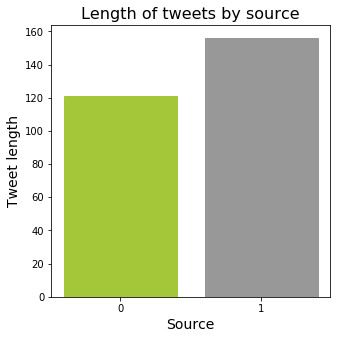

In [5]:
def length_vs_label(x,y):
    labels = np.unique(y)
    avgs = []
    for label in labels:
        avg = 0
        count = 0
        for text in x[y==label]:
            avg += len(text)
            count+=1
        avg /= count
        avgs.append(avg)
    
    plt.figure(figsize=(5,5))
    bars = plt.bar([str(label) for label in labels], avgs)
    bars[0].set_color('#a4c639') # android
    bars[1].set_color('#989898') # spacegray
    plt.title('Length of tweets by source', fontsize=16)
    plt.ylabel('Tweet length', fontsize=14)
    plt.xlabel('Source', fontsize=14)
    plt.show()
    
length_vs_label(X_train, y_train) # iPhone tweets longer than Android tweets on average

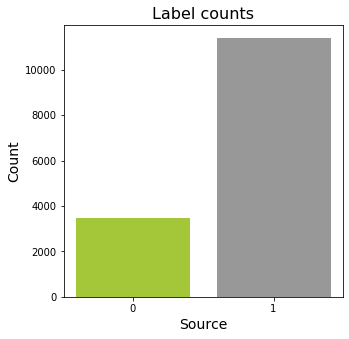

In [6]:
def label_counts(y):
    unique = np.unique(y_train, return_counts=True)
    
    plt.figure(figsize=(5,5))
    bars = plt.bar([str(u) for u in unique[0]], unique[1])
    bars[0].set_color('#a4c639') # android
    bars[1].set_color('#989898') # spacegray
    plt.title('Label counts', fontsize=16)
    plt.ylabel('Count', fontsize=14)
    plt.xlabel('Source', fontsize=14)
    plt.show()
    
label_counts(y_train) # more iPhone tweets than Android

### Tokenize Text for Embedding Layer

In [7]:
#create word-to-index dictionary
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# convert text to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# tokenizer dictionary
dictionary = tokenizer.word_index

In [8]:
#length of current dictionary vocab
vocab_size = len(tokenizer.word_index) + 1

maxlen = 65

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### construct embeddings using a glove model

In [9]:
embeddings_dictionary = dict()

#file is too large to store on git, must download and place in folder manually
glove_file = open('./glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [10]:
#create embedding matrix
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [11]:
vocab_size == len(embedding_matrix)

True

### BALANCING

In [16]:
from keras.utils import to_categorical
from imblearn.keras import balanced_batch_generator
from imblearn.under_sampling import NearMiss

In [17]:
y_train_balance = to_categorical(y_train, num_classes=2)
y_test_balance = to_categorical(y_test, num_classes=2)

# Feed Forward Network

In [12]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 65, 100)           2441300   
_________________________________________________________________
flatten_1 (Flatten)          (None, 6500)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6501      
Total params: 2,447,801
Trainable params: 6,501
Non-trainable params: 2,441,300
_________________________________________________________________
None


In [14]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('./models/best_ffn.h5', monitor='val_acc', verbose=1, mode='max',  save_best_only=True)

ffn_history = model.fit(X_train, y_train, 
                        batch_size=128, 
                        epochs=1000, 
                        verbose=0, 
                        validation_split=0.2,
                        callbacks = [es])

Epoch 00057: early stopping


In [15]:
model = load_model('./models/best_ffn.h5')
model.evaluate(X_test, y_test, verbose=1)

3720/3720 [==============================] - 0s 34us/step


[0.37758335336562127, 0.8037634491920471]

In [18]:
model_balance = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model_balance.add(embedding_layer)

model_balance.add(Flatten())
model_balance.add(Dense(2, activation='sigmoid'))

In [19]:
model_balance.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model_balance.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 65, 100)           2441300   
_________________________________________________________________
flatten_2 (Flatten)          (None, 6500)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 13002     
Total params: 2,454,302
Trainable params: 13,002
Non-trainable params: 2,441,300
_________________________________________________________________
None


In [20]:
training_generator, steps_per_epoch = balanced_batch_generator(X_train, y_train_balance, 
                                                               sampler=NearMiss(),
                                                               batch_size=128, 
                                                               random_state=42)

In [21]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('./models/best_ffnb.h5', monitor='val_acc', verbose=1, mode='max',  save_best_only=True)

balanced_history_ffn = model_balance.fit_generator(generator=training_generator, 
                                                   steps_per_epoch=steps_per_epoch, 
                                                   epochs=1000, 
                                                   verbose=0, 
                                                   validation_data=(X_test, y_test_balance),
                                                   callbacks=[es])

Epoch 00056: early stopping


In [22]:
model_balance = load_model('./models/best_ffnb.h5')
model_balance.evaluate(X_test, y_test_balance)

3720/3720 [==============================] - 0s 39us/step


[0.4719137331490876, 0.7909946441650391]

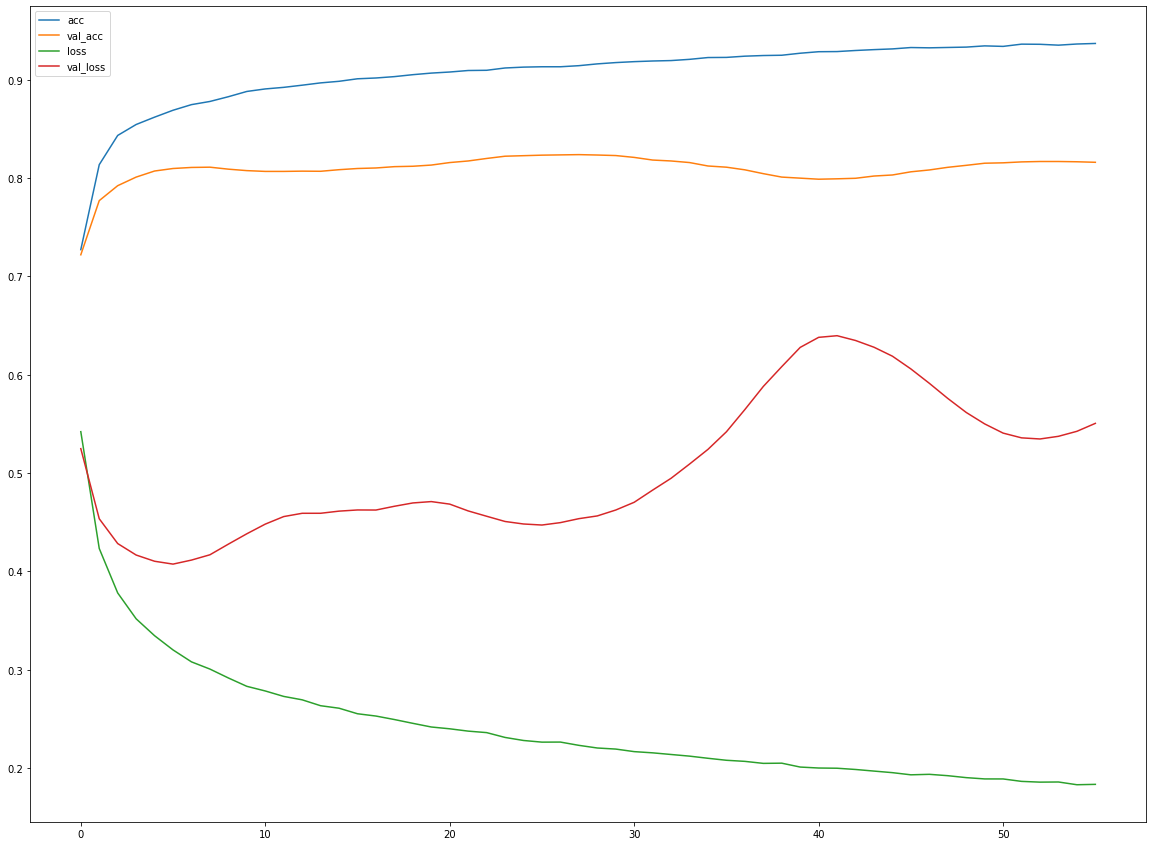

In [23]:
plt.figure(figsize=(20,15))
plt.plot(balanced_history_ffn.history['acc'])
plt.plot(balanced_history_ffn.history['val_acc'])
plt.plot(balanced_history_ffn.history['loss'])
plt.plot(balanced_history_ffn.history['val_loss'])
plt.legend(['acc','val_acc','loss','val_loss'])
plt.show()

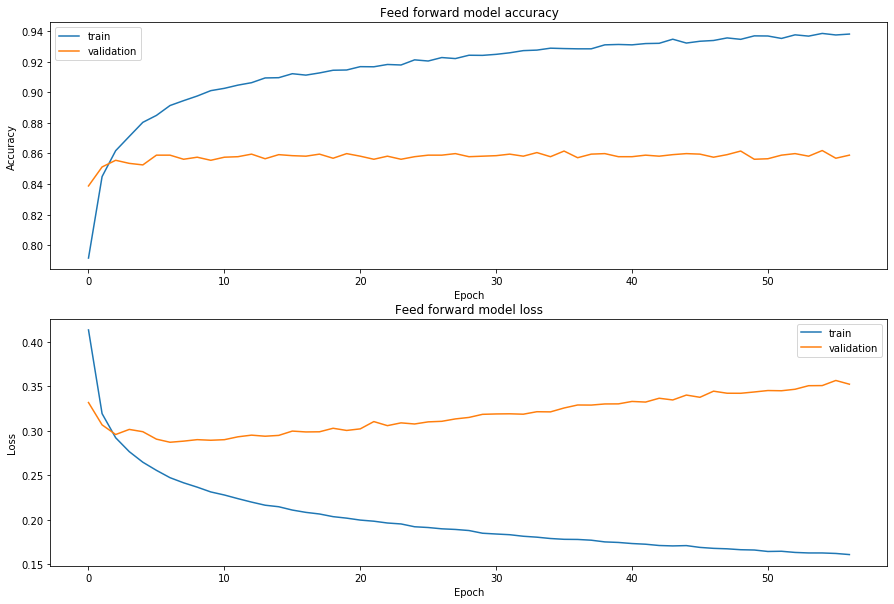

In [24]:
# plots
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(ffn_history.history['acc'])
plt.plot(ffn_history.history['val_acc'])
plt.title('Feed forward model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','validation'], loc='upper left')

plt.subplot(2,1,2)
plt.plot(ffn_history.history['loss'])
plt.plot(ffn_history.history['val_loss'])
plt.title('Feed forward model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()

# CNN

In [48]:
cnn = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn.add(embedding_layer)

cnn.add(Conv1D(128, 5, activation='relu'))
cnn.add(GlobalMaxPooling1D())

#add a vanilla hidden layer:
cnn.add(Dense(128))
cnn.add(Activation('relu'))


cnn.add(Dense(1, activation='sigmoid'))
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [49]:
print(cnn.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 65, 100)           2441300   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 61, 128)           64128     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_6 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 129       
Total params: 2,522,069
Trainable params: 80,769
Non-trainable params: 2,441,300
_______________________________________

In [50]:
cnn = load_model('./models/best_cnn.h5')

In [51]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('./models/best_cnn.h5', monitor='val_acc', verbose=1, mode='max',  save_best_only=True)

cnn_history = cnn.fit(X_train, y_train, 
                      batch_size=128, 
                      epochs=1000, 
                      verbose=0, 
                      validation_data = (X_test,y_test), 
                      callbacks=[es, mc])


Epoch 00001: val_acc improved from -inf to 0.82823, saving model to ./models/best_cnn.h5

Epoch 00002: val_acc did not improve from 0.82823

Epoch 00003: val_acc improved from 0.82823 to 0.82903, saving model to ./models/best_cnn.h5

Epoch 00004: val_acc improved from 0.82903 to 0.84785, saving model to ./models/best_cnn.h5

Epoch 00005: val_acc did not improve from 0.84785

Epoch 00006: val_acc did not improve from 0.84785

Epoch 00007: val_acc did not improve from 0.84785

Epoch 00008: val_acc did not improve from 0.84785

Epoch 00009: val_acc improved from 0.84785 to 0.84866, saving model to ./models/best_cnn.h5

Epoch 00010: val_acc did not improve from 0.84866

Epoch 00011: val_acc did not improve from 0.84866

Epoch 00012: val_acc did not improve from 0.84866

Epoch 00013: val_acc improved from 0.84866 to 0.85215, saving model to ./models/best_cnn.h5

Epoch 00014: val_acc improved from 0.85215 to 0.85242, saving model to ./models/best_cnn.h5

Epoch 00015: val_acc improved from 0

In [52]:
cnn = load_model('./models/best_cnn.h5')
cnn.evaluate(X_test, y_test, verbose=1)

3720/3720 [==============================] - 0s 44us/step


[0.8988740501544809, 0.8596774339675903]

### BALANCING CNN

In [53]:
cnn_balance = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_balance.add(embedding_layer)

cnn_balance.add(Conv1D(128, 5, activation='relu'))
cnn_balance.add(GlobalMaxPooling1D())
#add a vanilla hidden layer:
cnn.add(Dense(128))
cnn.add(Activation('relu'))
cnn.add(Dense(1, activation='sigmoid'))
cnn_balance.add(Dense(2, activation='sigmoid'))

cnn_balance.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [54]:
cnn_balance.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(cnn_balance.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 65, 100)           2441300   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 61, 128)           64128     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 258       
Total params: 2,505,686
Trainable params: 64,386
Non-trainable params: 2,441,300
_________________________________________________________________
None


In [55]:
training_generator, steps_per_epoch = balanced_batch_generator(X_train, y_train_balance, 
                                                               sampler=NearMiss(), 
                                                               batch_size=128, 
                                                               random_state=42)

In [56]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('./models/best_cnnb.h5', monitor='val_acc', verbose=1, mode='max',  save_best_only=True)

balanced_history_cnn = cnn_balance.fit_generator(generator=training_generator, 
                                                 steps_per_epoch=steps_per_epoch, 
                                                 epochs=1000, verbose=1, 
                                                 validation_data=(X_test, y_test_balance),
                                                 callbacks=[es, mc]
                                                )

Epoch 1/1000
54/54 [==============================] - 0s 9ms/step - loss: 0.4616 - acc: 0.7866 - val_loss: 0.7961 - val_acc: 0.5500

Epoch 00001: val_acc improved from -inf to 0.55000, saving model to ./models/best_cnnb.h5
Epoch 2/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.3302 - acc: 0.8665 - val_loss: 0.7455 - val_acc: 0.6070

Epoch 00002: val_acc improved from 0.55000 to 0.60699, saving model to ./models/best_cnnb.h5
Epoch 3/1000
54/54 [==============================] - 0s 5ms/step - loss: 0.2765 - acc: 0.8910 - val_loss: 0.7272 - val_acc: 0.6194

Epoch 00003: val_acc improved from 0.60699 to 0.61935, saving model to ./models/best_cnnb.h5
Epoch 4/1000
54/54 [==============================] - 0s 5ms/step - loss: 0.2377 - acc: 0.9100 - val_loss: 0.6981 - val_acc: 0.6406

Epoch 00004: val_acc improved from 0.61935 to 0.64059, saving model to ./models/best_cnnb.h5
Epoch 5/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.2065 - acc: 0.9244 - va

54/54 [==============================] - 0s 5ms/step - loss: 0.0131 - acc: 0.9964 - val_loss: 1.7048 - val_acc: 0.6497

Epoch 00043: val_acc did not improve from 0.76505
Epoch 44/1000
54/54 [==============================] - 0s 5ms/step - loss: 0.0114 - acc: 0.9966 - val_loss: 1.6913 - val_acc: 0.6511

Epoch 00044: val_acc did not improve from 0.76505
Epoch 45/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.0113 - acc: 0.9966 - val_loss: 1.6888 - val_acc: 0.6522

Epoch 00045: val_acc did not improve from 0.76505
Epoch 46/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.0110 - acc: 0.9969 - val_loss: 1.6852 - val_acc: 0.6531

Epoch 00046: val_acc did not improve from 0.76505
Epoch 47/1000
54/54 [==============================] - 0s 5ms/step - loss: 0.0110 - acc: 0.9968 - val_loss: 1.6927 - val_acc: 0.6532

Epoch 00047: val_acc did not improve from 0.76505
Epoch 48/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.0110 - acc: 0.996

In [57]:
cnn_balance =load_model('./models/best_cnnb.h5')
cnn_balance.evaluate(X_test, y_test_balance)

3720/3720 [==============================] - 0s 42us/step


[0.815643060207367, 0.7650537490844727]

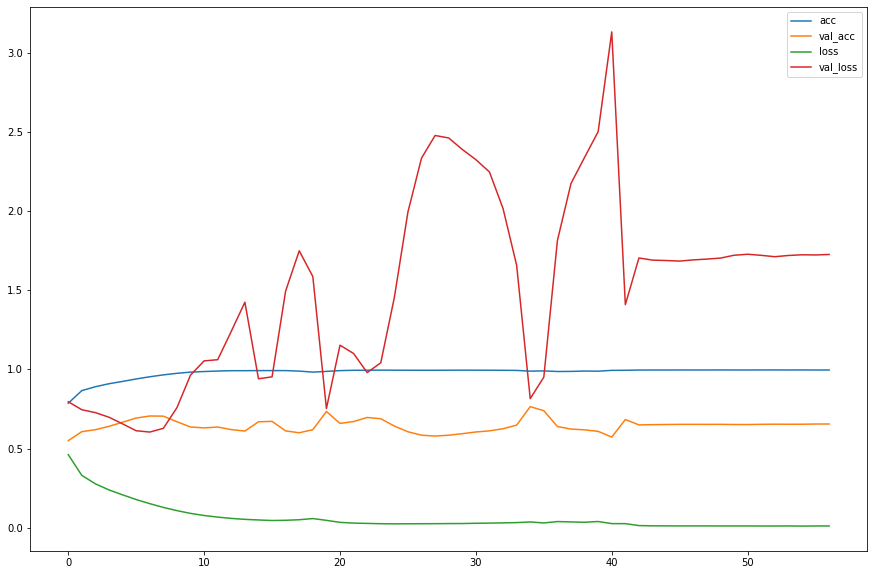

In [58]:
plt.figure(figsize=(15,10))
plt.plot(balanced_history_cnn.history['acc'])
plt.plot(balanced_history_cnn.history['val_acc'])
plt.plot(balanced_history_cnn.history['loss'])
plt.plot(balanced_history_cnn.history['val_loss'])
plt.legend(['acc','val_acc','loss','val_loss'])
plt.show()

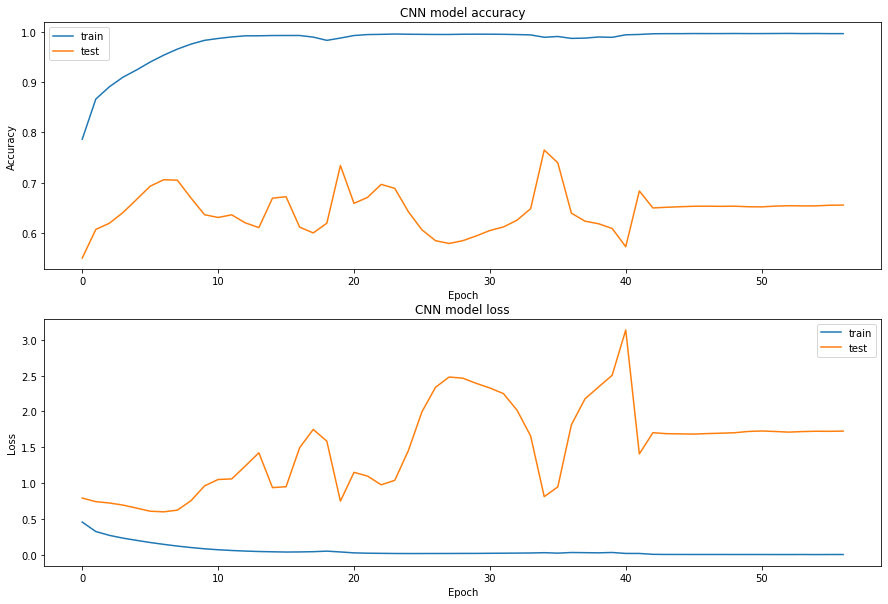

In [59]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(balanced_history_cnn.history['acc'])
plt.plot(balanced_history_cnn.history['val_acc'])
plt.title('CNN model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc = 'upper left')

plt.subplot(2,1,2)
plt.plot(balanced_history_cnn.history['loss'])
plt.plot(balanced_history_cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc = 'upper right')
plt.show()

# LSTM model

In [60]:
lstm_model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))
lstm_model.add(Dense(128))
lstm_model.add(Activation('relu'))

lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [61]:
print(lstm_model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 65, 100)           2441300   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_8 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 129       
Total params: 2,575,189
Trainable params: 133,889
Non-trainable params: 2,441,300
_________________________________________________________________
None


In [62]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('./models/best_lstm.h5', monitor='val_acc', verbose=1, mode='max',  save_best_only=True)

lstm_history = lstm_model.fit(X_train, y_train,
                              batch_size=128, 
                              epochs=1000, 
                              verbose=0, 
                              validation_data=(X_test, y_test),
                              callbacks=[es, mc])

lstm_score = lstm_model.evaluate(X_test, y_test, verbose=1)


Epoch 00001: val_acc improved from -inf to 0.75538, saving model to ./models/best_lstm.h5

Epoch 00002: val_acc improved from 0.75538 to 0.78387, saving model to ./models/best_lstm.h5

Epoch 00003: val_acc improved from 0.78387 to 0.85780, saving model to ./models/best_lstm.h5

Epoch 00004: val_acc did not improve from 0.85780

Epoch 00005: val_acc did not improve from 0.85780

Epoch 00006: val_acc improved from 0.85780 to 0.88306, saving model to ./models/best_lstm.h5

Epoch 00007: val_acc did not improve from 0.88306

Epoch 00008: val_acc improved from 0.88306 to 0.89005, saving model to ./models/best_lstm.h5

Epoch 00009: val_acc improved from 0.89005 to 0.89140, saving model to ./models/best_lstm.h5

Epoch 00010: val_acc did not improve from 0.89140

Epoch 00011: val_acc did not improve from 0.89140

Epoch 00012: val_acc did not improve from 0.89140

Epoch 00013: val_acc did not improve from 0.89140

Epoch 00014: val_acc did not improve from 0.89140

Epoch 00015: val_acc did not i

In [63]:
lstm_model = load_model('./models/best_lstm.h5')
lstm_model.evaluate(X_test, y_test)

3720/3720 [==============================] - 2s 503us/step


[0.2779264856410283, 0.9013440608978271]

### BALANCE

In [64]:
lstm_model_balance = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model_balance.add(embedding_layer)
lstm_model_balance.add(LSTM(128))
lstm_model_balance.add(Dense(128))
lstm_model_balance.add(Activation('relu'))
lstm_model_balance.add(Dense(2, activation='sigmoid'))

lstm_model_balance.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [65]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('./models/best_lstmb.h5', monitor='val_acc', verbose=1, mode='max',  save_best_only=True)

balanced_history_lstm = lstm_model_balance.fit_generator(generator=training_generator, 
                                                         steps_per_epoch=steps_per_epoch,
                                                         epochs=1000, 
                                                         verbose=1, 
                                                         validation_data=(X_test, y_test_balance),
                                                         callbacks=[es, mc])

Epoch 1/1000
54/54 [==============================] - 3s 50ms/step - loss: 0.5595 - acc: 0.7307 - val_loss: 0.7070 - val_acc: 0.4824

Epoch 00001: val_acc improved from -inf to 0.48239, saving model to ./models/best_lstmb.h5
Epoch 2/1000
54/54 [==============================] - 2s 43ms/step - loss: 0.4606 - acc: 0.7939 - val_loss: 0.6184 - val_acc: 0.5933

Epoch 00002: val_acc improved from 0.48239 to 0.59328, saving model to ./models/best_lstmb.h5
Epoch 3/1000
54/54 [==============================] - 2s 45ms/step - loss: 0.4105 - acc: 0.8193 - val_loss: 0.7810 - val_acc: 0.6280

Epoch 00003: val_acc improved from 0.59328 to 0.62796, saving model to ./models/best_lstmb.h5
Epoch 4/1000
54/54 [==============================] - 2s 44ms/step - loss: 0.3627 - acc: 0.8438 - val_loss: 0.8313 - val_acc: 0.6215

Epoch 00004: val_acc did not improve from 0.62796
Epoch 5/1000
54/54 [==============================] - 2s 43ms/step - loss: 0.3326 - acc: 0.8617 - val_loss: 0.9086 - val_acc: 0.6087

E

54/54 [==============================] - 2s 45ms/step - loss: 0.0641 - acc: 0.9815 - val_loss: 1.6006 - val_acc: 0.6867

Epoch 00044: val_acc did not improve from 0.77487
Epoch 45/1000
54/54 [==============================] - 2s 46ms/step - loss: 0.0547 - acc: 0.9845 - val_loss: 1.8053 - val_acc: 0.6636

Epoch 00045: val_acc did not improve from 0.77487
Epoch 46/1000
54/54 [==============================] - 2s 45ms/step - loss: 0.0477 - acc: 0.9881 - val_loss: 1.6379 - val_acc: 0.6927

Epoch 00046: val_acc did not improve from 0.77487
Epoch 47/1000
54/54 [==============================] - 2s 46ms/step - loss: 0.1298 - acc: 0.9591 - val_loss: 0.8756 - val_acc: 0.6902

Epoch 00047: val_acc did not improve from 0.77487
Epoch 48/1000
54/54 [==============================] - 2s 46ms/step - loss: 0.2639 - acc: 0.8955 - val_loss: 1.2139 - val_acc: 0.6714

Epoch 00048: val_acc did not improve from 0.77487
Epoch 49/1000
54/54 [==============================] - 2s 46ms/step - loss: 0.1787 - acc:

In [66]:
lstm_model_balance = load_model('./models/best_lstmb.h5')
lstm_model_balance.evaluate(X_test, y_test_balance)

3720/3720 [==============================] - 2s 517us/step


[0.5700675519563818, 0.7748655676841736]

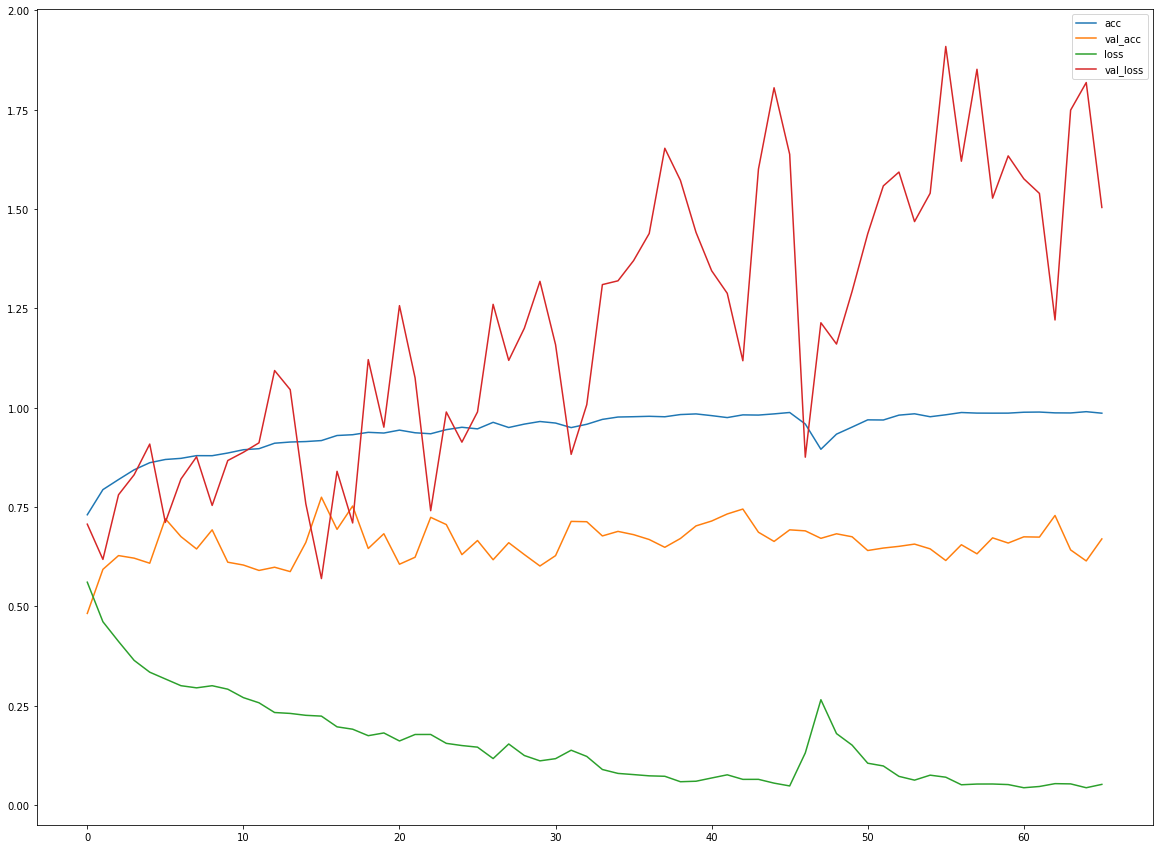

In [67]:
plt.figure(figsize=(20,15))
plt.plot(balanced_history_lstm.history['acc'])
plt.plot(balanced_history_lstm.history['val_acc'])
plt.plot(balanced_history_lstm.history['loss'])
plt.plot(balanced_history_lstm.history['val_loss'])
plt.legend(['acc','val_acc','loss','val_loss'])
plt.show()

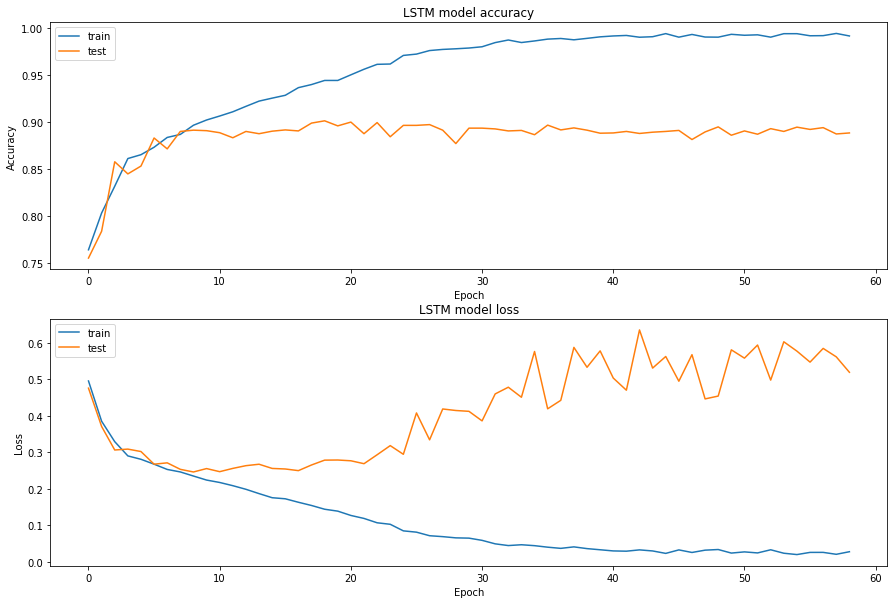

In [68]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(lstm_history.history['acc'])
plt.plot(lstm_history.history['val_acc'])
plt.title('LSTM model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='upper left')

plt.subplot(2,1,2)
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('LSTM model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [69]:
lstm_model.predict(X_test)[2]

array([0.99997735], dtype=float32)

# Bidirectional LSTM

In [74]:
bi = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

bi.add(embedding_layer)
bi.add(Bidirectional(LSTM(128)))
bi.add(Dense(128))
bi.add(Activation('relu'))


bi.add(Dense(1, activation='sigmoid'))
       
bi.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])       

In [75]:
print(bi.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 65, 100)           2441300   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               234496    
_________________________________________________________________
dense_26 (Dense)             (None, 128)               32896     
_________________________________________________________________
activation_11 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 129       
Total params: 2,708,821
Trainable params: 267,521
Non-trainable params: 2,441,300
_________________________________________________________________
None


In [76]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('./models/best_bi.h5', monitor='val_acc', verbose=1, mode='max',  save_best_only=True)

bi_history = bi.fit(X_train, 
                    y_train, 
                    batch_size=128, 
                    epochs=1000, 
                    verbose=0,
                    validation_split=0.2, 
                    callbacks=[mc,es])

bi_score = bi.evaluate(X_test, y_test, verbose=1)


Epoch 00001: val_acc improved from -inf to 0.86828, saving model to ./models/best_bi.h5

Epoch 00002: val_acc improved from 0.86828 to 0.86962, saving model to ./models/best_bi.h5

Epoch 00003: val_acc improved from 0.86962 to 0.88239, saving model to ./models/best_bi.h5

Epoch 00004: val_acc did not improve from 0.88239

Epoch 00005: val_acc did not improve from 0.88239

Epoch 00006: val_acc improved from 0.88239 to 0.89113, saving model to ./models/best_bi.h5

Epoch 00007: val_acc did not improve from 0.89113

Epoch 00008: val_acc improved from 0.89113 to 0.89247, saving model to ./models/best_bi.h5

Epoch 00009: val_acc did not improve from 0.89247

Epoch 00010: val_acc did not improve from 0.89247

Epoch 00011: val_acc did not improve from 0.89247

Epoch 00012: val_acc did not improve from 0.89247

Epoch 00013: val_acc did not improve from 0.89247

Epoch 00014: val_acc did not improve from 0.89247

Epoch 00015: val_acc did not improve from 0.89247

Epoch 00016: val_acc did not imp

In [77]:
print("Test Score:", bi_score[0])
print("Test Accuracy:", bi_score[1])

Test Score: 0.8621046031875316
Test Accuracy: 0.8879032135009766


## Balance

In [91]:
bi_balance = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

bi_balance.add(embedding_layer)
bi_balance.add(Bidirectional(LSTM(128)))
bi_balance.add(Dense(128))
bi_balance.add(Activation('relu'))
bi_balance.add(Dense(2, activation='sigmoid'))
       
bi_balance.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])       

In [92]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('./models/best_bib.h5', monitor='val_acc', verbose=1, mode='max',  save_best_only=True)

balanced_history_bi= bi_balance.fit_generator(generator=training_generator, 
                                                         steps_per_epoch=steps_per_epoch,
                                                         epochs=10000, 
                                                         verbose=0, 
                                                         validation_data=(X_test, y_test_balance),
                                                         callbacks=[es,mc])

bi_score = bi_balance.evaluate(X_test, y_test_balance, verbose=1)


Epoch 00001: val_acc improved from -inf to 0.60255, saving model to ./models/best_bib.h5

Epoch 00002: val_acc improved from 0.60255 to 0.60484, saving model to ./models/best_bib.h5

Epoch 00003: val_acc improved from 0.60484 to 0.62312, saving model to ./models/best_bib.h5

Epoch 00004: val_acc improved from 0.62312 to 0.64597, saving model to ./models/best_bib.h5

Epoch 00005: val_acc did not improve from 0.64597

Epoch 00006: val_acc improved from 0.64597 to 0.66048, saving model to ./models/best_bib.h5

Epoch 00007: val_acc improved from 0.66048 to 0.69099, saving model to ./models/best_bib.h5

Epoch 00008: val_acc improved from 0.69099 to 0.78508, saving model to ./models/best_bib.h5

Epoch 00009: val_acc did not improve from 0.78508

Epoch 00010: val_acc did not improve from 0.78508

Epoch 00011: val_acc did not improve from 0.78508

Epoch 00012: val_acc did not improve from 0.78508

Epoch 00013: val_acc did not improve from 0.78508

Epoch 00014: val_acc did not improve from 0.7

In [93]:
print("Test Score:", bi_score[0])
print("Test Accuracy:", bi_score[1])

Test Score: 2.1170851784367715
Test Accuracy: 0.7552419304847717


## GRU

In [83]:
gru = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

gru.add(embedding_layer)
gru.add(GRU(128))
gru.add(Dense(128))
gru.add(Activation('relu'))


gru.add(Dense(1, activation='sigmoid'))
       
gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])    

In [85]:
gru.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 65, 100)           2441300   
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               87936     
_________________________________________________________________
dense_30 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_12 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 129       
Total params: 2,545,877
Trainable params: 104,577
Non-trainable params: 2,441,300
_________________________________________________________________


In [84]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('./models/best_gru.h5', monitor='val_acc', verbose=1, mode='max',  save_best_only=True)

gru_history = bi.fit(X_train, 
                    y_train, 
                    batch_size=128, 
                    epochs=1000, 
                    verbose=0,
                    validation_split=0.2, 
                    callbacks=[mc,es])

gru_score = bi.evaluate(X_test, y_test, verbose=1)


Epoch 00001: val_acc improved from -inf to 0.89113, saving model to ./models/best_gru.h5

Epoch 00002: val_acc did not improve from 0.89113

Epoch 00003: val_acc improved from 0.89113 to 0.89180, saving model to ./models/best_gru.h5

Epoch 00004: val_acc did not improve from 0.89180

Epoch 00005: val_acc did not improve from 0.89180

Epoch 00006: val_acc did not improve from 0.89180

Epoch 00007: val_acc improved from 0.89180 to 0.89281, saving model to ./models/best_gru.h5

Epoch 00008: val_acc did not improve from 0.89281

Epoch 00009: val_acc did not improve from 0.89281

Epoch 00010: val_acc did not improve from 0.89281

Epoch 00011: val_acc did not improve from 0.89281

Epoch 00012: val_acc did not improve from 0.89281

Epoch 00013: val_acc did not improve from 0.89281

Epoch 00014: val_acc did not improve from 0.89281

Epoch 00015: val_acc improved from 0.89281 to 0.89315, saving model to ./models/best_gru.h5

Epoch 00016: val_acc did not improve from 0.89315

Epoch 00017: val_a

In [86]:
gru_score

[1.18637836772588, 0.8870967626571655]

### Balanced

In [89]:
gru_balance = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

gru_balance.add(embedding_layer)
gru_balance.add(GRU(128))
gru_balance.add(Dense(128))
gru_balance.add(Activation('relu'))
gru_balance.add(Dense(2, activation='sigmoid'))
       
gru_balance.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc']) 

In [90]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('./models/best_grub.h5', monitor='val_acc', verbose=1, mode='max',  save_best_only=True)

balanced_history_gru= gru_balance.fit_generator(generator=training_generator, 
                                                         steps_per_epoch=steps_per_epoch, 
                                                         epochs=1000, 
                                                         verbose=0, 
                                                         validation_data=(X_test, y_test_balance),
                                                         callbacks=[es,mc])

grub_score = gru_balance.evaluate(X_test, y_test_balance, verbose=1)
grub_score


Epoch 00001: val_acc improved from -inf to 0.75538, saving model to ./models/best_grub.h5

Epoch 00002: val_acc did not improve from 0.75538

Epoch 00003: val_acc did not improve from 0.75538

Epoch 00004: val_acc did not improve from 0.75538

Epoch 00005: val_acc did not improve from 0.75538

Epoch 00006: val_acc did not improve from 0.75538

Epoch 00007: val_acc did not improve from 0.75538

Epoch 00008: val_acc did not improve from 0.75538

Epoch 00009: val_acc did not improve from 0.75538

Epoch 00010: val_acc did not improve from 0.75538

Epoch 00011: val_acc did not improve from 0.75538

Epoch 00012: val_acc did not improve from 0.75538

Epoch 00013: val_acc did not improve from 0.75538

Epoch 00014: val_acc did not improve from 0.75538

Epoch 00015: val_acc did not improve from 0.75538

Epoch 00016: val_acc did not improve from 0.75538

Epoch 00017: val_acc did not improve from 0.75538

Epoch 00018: val_acc did not improve from 0.75538

Epoch 00019: val_acc did not improve from

[0.6943687890165595, 0.24489247798919678]